In [ ]:
!pip install keras-tuner --quiet
!pip install yfinance --quiet


In [ ]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau






plt.style.use('ggplot')

In [ ]:
import yfinance as yf
import datetime as dt
import pandas as pd

def fetch_stock_data_corrected():

    tickers_input = input('Enter stock tickers separated by commas (e.g., AAPL,GOOGL): ').upper()
    tickers = tickers_input.split(',')  # Split input into a list of tickers
    start_year = int(input('Enter start year (e.g., 2018): '))
    default_end = dt.datetime.now().year
    end_year_input = input(f'Enter end year (e.g., {default_end}, press Enter for {default_end}): ')
    end_year = int(end_year_input) if end_year_input else default_end

    start = dt.datetime(start_year, 1, 1)
    end = dt.datetime.now()

    print(f'\nFetching data for {tickers_input} from {start.year} to {end.year}...')
    try:
        wide_df = yf.download(
            tickers,
            start=start,
            end=end,
            progress=False,
            auto_adjust=False
        )

        if wide_df.empty:
            raise ValueError(f'No data found for {tickers_input}.')

        long_df = wide_df.stack().reset_index()

        long_df.rename(columns={'level_1': 'Ticker', 'Adj Close': 'Price'}, inplace=True)

        long_df.to_csv('stock_data_backup.csv', index=False)

        stock_data_dict = {}
        for ticker in tickers:
            stock_data_dict[ticker] = long_df[long_df['Ticker'] == ticker]

        print(f"Success: {len(long_df)} records retrieved")
        print(f"Backup saved as 'stock_data_backup.csv'")

        return long_df, stock_data_dict

    except Exception as e:
        print(f"Error: {e}")
        return None, None

stock_data, stock_data_dict = fetch_stock_data_corrected()

if stock_data is not None:
    print(stock_data.head())
else:
    print("Failed to fetch data.")

if stock_data_dict is not None:
    for ticker, data in stock_data_dict.items():
        print(f"\nData for {ticker}:")
        print(data.head())


Enter stock tickers separated by commas (e.g., AAPL,GOOGL): aapl
Enter start year (e.g., 2018): 2021
Enter end year (e.g., 2025, press Enter for 2025): 

Fetching data for AAPL from 2021 to 2025...
Success: 1145 records retrieved
Backup saved as 'stock_data_backup.csv'
Price       Date Ticker       Price       Close        High         Low  \
0     2021-01-04   AAPL  126.239693  129.410004  133.610001  126.760002   
1     2021-01-05   AAPL  127.800491  131.009995  131.740005  128.429993   
2     2021-01-06   AAPL  123.498512  126.599998  131.050003  126.379997   
3     2021-01-07   AAPL  127.712677  130.919998  131.630005  127.860001   
4     2021-01-08   AAPL  128.815033  132.050003  132.630005  130.229996   

Price        Open     Volume  
0      133.520004  143301900  
1      128.889999   97664900  
2      127.720001  155088000  
3      128.360001  109578200  
4      132.429993  105158200  

Data for AAPL:
Price       Date Ticker       Price       Close        High         Low  \
0 

/tmp/ipython-input-3-1077720257.py:30: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long_df = wide_df.stack().reset_index()


In [ ]:
from IPython.display import display

if stock_data is not None:
    print("Enhancing data with analytical columns...")

    stock_data.sort_values(by=['Ticker', 'Date'], inplace=True)

    stock_data['Change %'] = stock_data.groupby('Ticker')['Price'].pct_change() * 100

    stock_data['SMA_20'] = stock_data.groupby('Ticker')['Price'].transform(lambda x: x.rolling(window=20).mean())
    stock_data['SMA_50'] = stock_data.groupby('Ticker')['Price'].transform(lambda x: x.rolling(window=50).mean())


    def color_change(val):
        if pd.isna(val):
            return ''
        color = '#C00000' if val < 0 else '#00B050'
        return f'color: {color}; font-weight: bold;'

    styled_df = stock_data.style.format({
        'Price': '${:,.2f}',
        'Open': '${:,.2f}',
        'High': '${:,.2f}',
        'Low': '${:,.2f}',
        'Close': '${:,.2f}',
        'Volume': '{:,.0f}',
        'Change %': '{:,.2f}%',
        'SMA_20': '${:,.2f}',
        'SMA_50': '${:,.2f}',
    }, na_rep="-").applymap(color_change, subset=['Change %'])

    styled_df = styled_df.bar(
        subset=['Volume'], align='mid', color='#d6e5ff'
    ).background_gradient(
        cmap='Blues', subset=['Volume']
    ).set_caption(
        "Detailed Stock Data Overview"
    ).set_properties(
        **{'text-align': 'center'}
    ).hide(axis="index")

    tickers = stock_data['Ticker'].unique()

    for ticker in tickers:
        print(f"\nDisplaying data for {ticker}...\n")
        individual_stock_data = stock_data[stock_data['Ticker'] == ticker]

        individual_styled_df = individual_stock_data.style.format({
            'Price': '${:,.2f}',
            'Open': '${:,.2f}',
            'High': '${:,.2f}',
            'Low': '${:,.2f}',
            'Close': '${:,.2f}',
            'Volume': '{:,.0f}',
            'Change %': '{:,.2f}%',
            'SMA_20': '${:,.2f}',
            'SMA_50': '${:,.2f}',
        }, na_rep="-").applymap(color_change, subset=['Change %'])

        individual_styled_df = individual_styled_df.bar(
            subset=['Volume'], align='mid', color='#d6e5ff'
        ).background_gradient(
            cmap='Blues', subset=['Volume']
        ).set_caption(
            f"{ticker} Detailed Stock Data Overview"
        ).set_properties(
            **{'text-align': 'center'}
        ).hide(axis="index")

        display(individual_styled_df)

else:
    print("Data fetch failed. Cannot display table.")


Enhancing data with analytical columns...

Displaying data for AAPL...



/tmp/ipython-input-4-2930876364.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }, na_rep="-").applymap(color_change, subset=['Change %'])
/tmp/ipython-input-4-2930876364.py:58: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }, na_rep="-").applymap(color_change, subset=['Change %'])


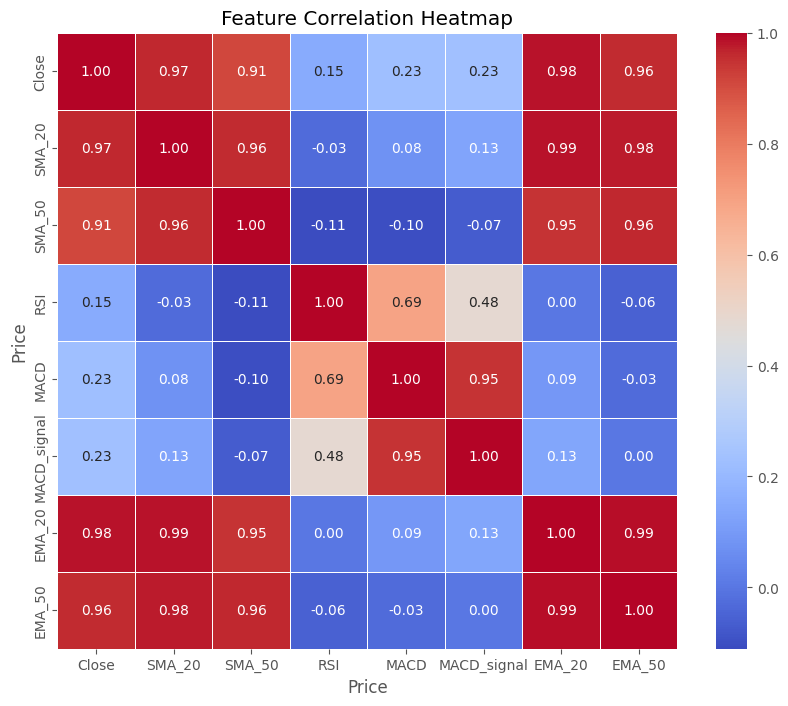

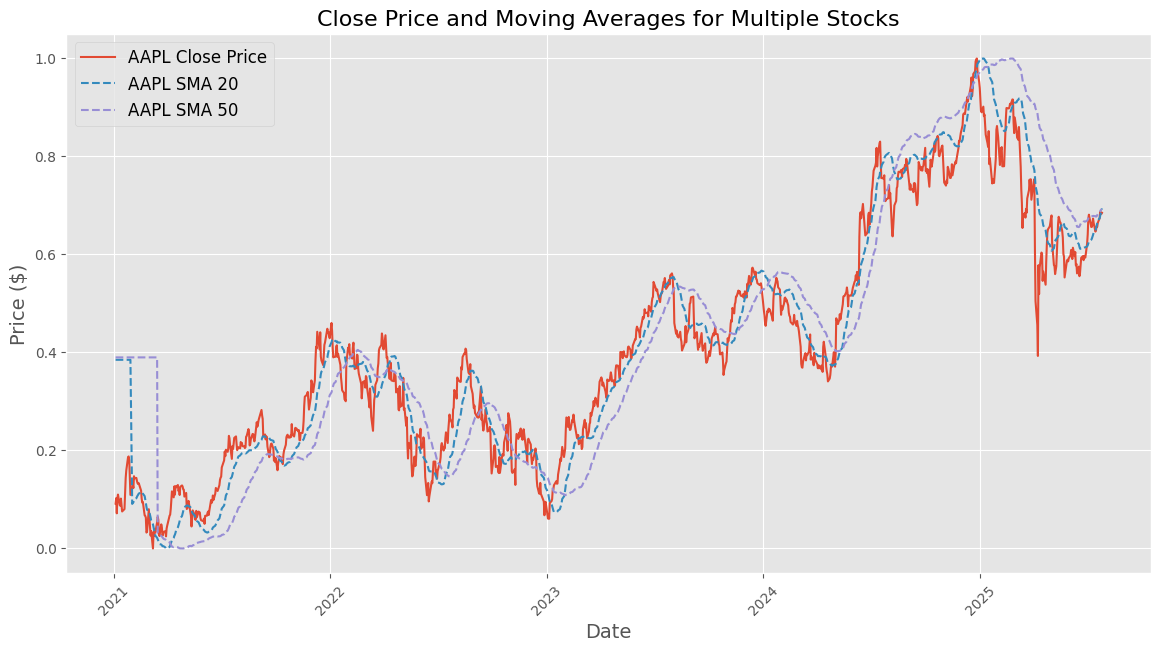

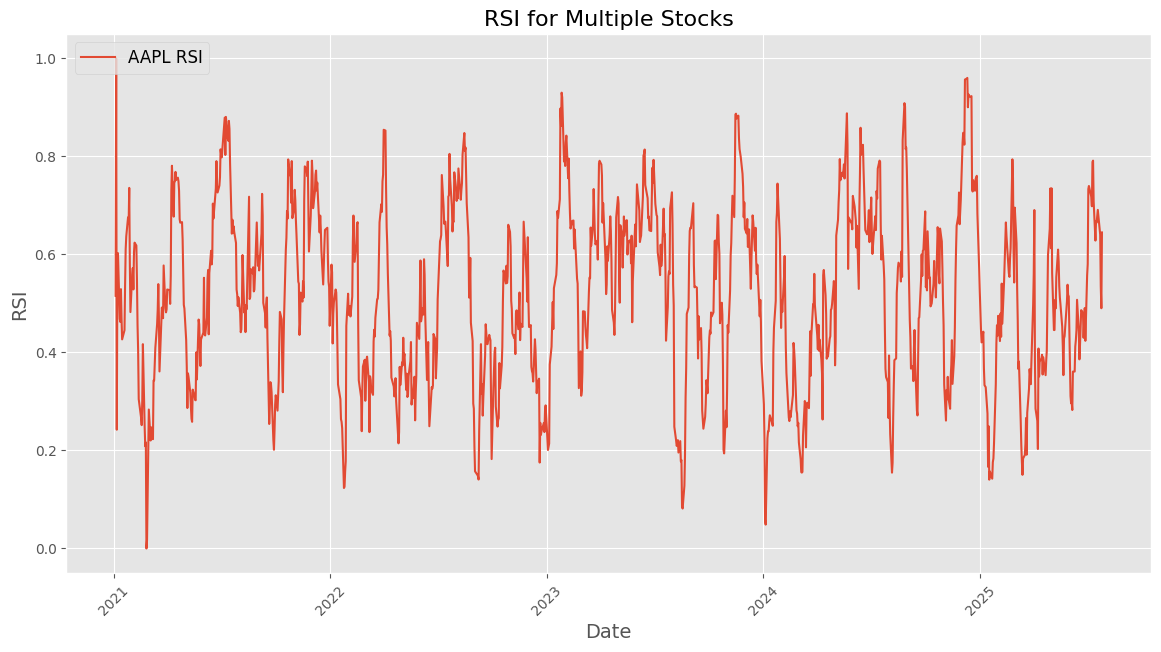

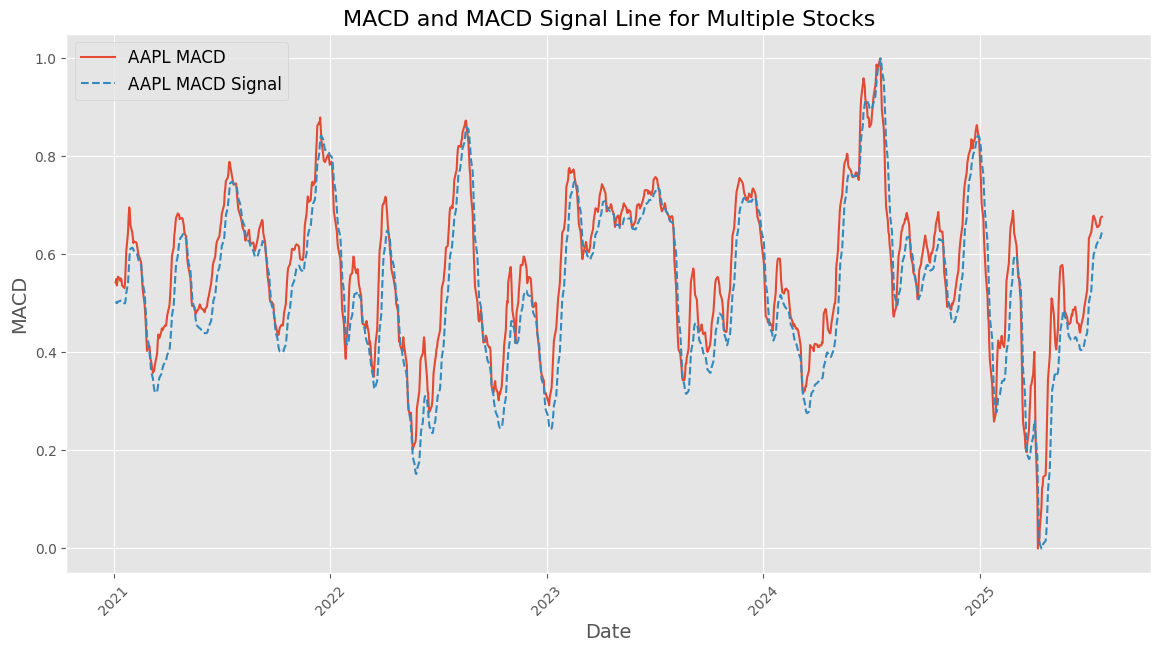

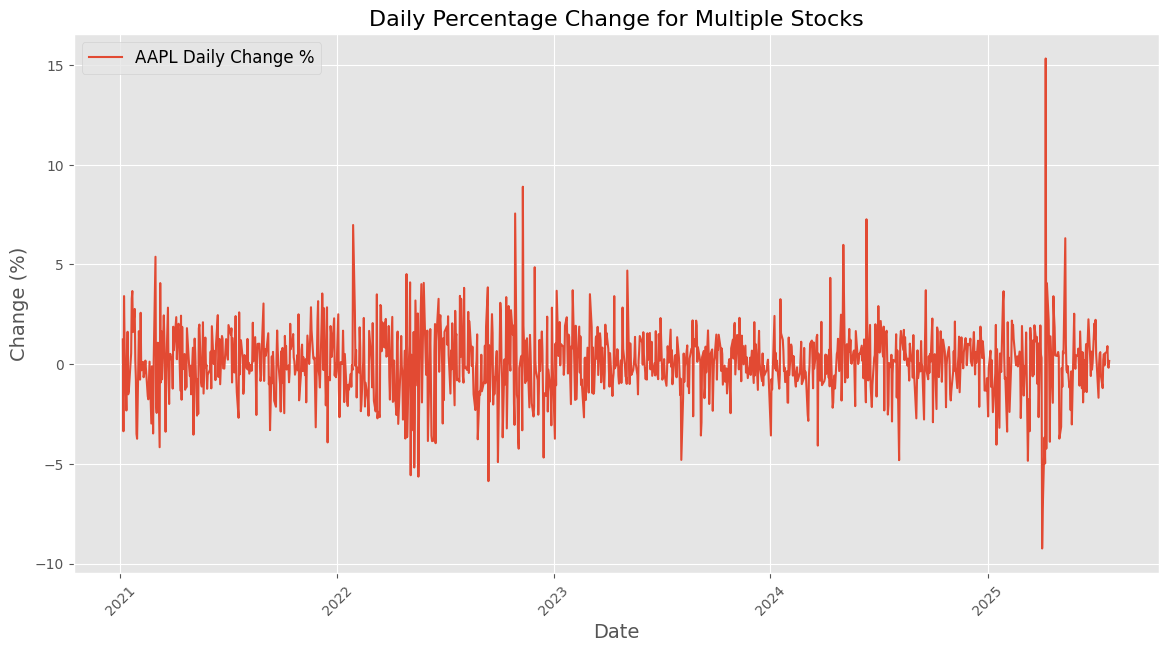

X_train shape: (868, 60, 8)
X_val shape: (108, 60, 8)
X_test shape: (109, 60, 8)
y_train shape: (868,)
y_val shape: (108,)
y_test shape: (109,)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_RSI(df, period=14):
    """Calculate Relative Strength Index (RSI) using pandas."""
    delta = df.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_MACD(df, fastperiod=12, slowperiod=26, signalperiod=9):
    """Calculate MACD using pandas."""
    fast_ema = df.ewm(span=fastperiod, min_periods=1, adjust=False).mean()
    slow_ema = df.ewm(span=slowperiod, min_periods=1, adjust=False).mean()
    macd = fast_ema - slow_ema
    macd_signal = macd.ewm(span=signalperiod, min_periods=1, adjust=False).mean()
    return macd, macd_signal

def calculate_EMA(df, window=50):
    """Calculate Exponential Moving Average (EMA)"""
    return df.ewm(span=window, adjust=False).mean()

def preprocess_data(stock_df, seq_len=60):
    """
    Preprocess the stock data for training an LSTM model.
    Includes data scaling, feature engineering (technical indicators),
    and splitting into train/validation/test sets.
    """
    stock_df = stock_df.sort_values(by='Date')

    # --- Feature Engineering ---
    stock_df['SMA_20'] = stock_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
    stock_df['SMA_50'] = stock_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=50).mean())

    stock_df['RSI'] = stock_df.groupby('Ticker')['Close'].transform(lambda x: calculate_RSI(x))

    macd_values = stock_df.groupby('Ticker')['Close'].transform(lambda x: calculate_MACD(x)[0])
    stock_df['MACD'] = macd_values
    macd_signal_values = stock_df.groupby('Ticker')['Close'].transform(lambda x: calculate_MACD(x)[1])
    stock_df['MACD_signal'] = macd_signal_values

    stock_df['EMA_20'] = stock_df.groupby('Ticker')['Close'].transform(lambda x: calculate_EMA(x, 20))
    stock_df['EMA_50'] = stock_df.groupby('Ticker')['Close'].transform(lambda x: calculate_EMA(x, 50))

    # --- Fill Missing Values ---
    imputer = SimpleImputer(strategy='median')
    stock_df[['SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'EMA_20', 'EMA_50']] = imputer.fit_transform(
        stock_df[['SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'EMA_20', 'EMA_50']])

    # --- Data Scaling ---
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'EMA_20', 'EMA_50']
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_df[features] = scaler.fit_transform(stock_df[features])

    X, y = [], []
    for i in range(seq_len, len(stock_df)):
        X.append(stock_df[features].iloc[i-seq_len:i].values)
        y.append(stock_df['Close'].iloc[i])

    X, y = np.array(X), np.array(y)

    # --- Train, Validation, Test Split ---
    # 80% train, 10% validation, 10% test (using temporal order)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, stock_df

def plot_correlation_heatmap(stock_df):
    correlation_matrix = stock_df[['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'EMA_20', 'EMA_50']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()

def plot_technical_indicators(stock_data):
    tickers = stock_data['Ticker'].unique()

    plt.style.use('ggplot')

    plt.figure(figsize=(14, 7))
    for ticker in tickers:
        individual_stock_data = stock_data[stock_data['Ticker'] == ticker]
        plt.plot(individual_stock_data['Date'], individual_stock_data['Close'], label=f'{ticker} Close Price')
        plt.plot(individual_stock_data['Date'], individual_stock_data['SMA_20'], label=f'{ticker} SMA 20', linestyle='--')
        plt.plot(individual_stock_data['Date'], individual_stock_data['SMA_50'], label=f'{ticker} SMA 50', linestyle='--')

    plt.title("Close Price and Moving Averages for Multiple Stocks", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Price ($)", fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 7))
    for ticker in tickers:
        individual_stock_data = stock_data[stock_data['Ticker'] == ticker]
        plt.plot(individual_stock_data['Date'], individual_stock_data['RSI'], label=f'{ticker} RSI')

    plt.title("RSI for Multiple Stocks", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("RSI", fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 7))
    for ticker in tickers:
        individual_stock_data = stock_data[stock_data['Ticker'] == ticker]
        plt.plot(individual_stock_data['Date'], individual_stock_data['MACD'], label=f'{ticker} MACD')
        plt.plot(individual_stock_data['Date'], individual_stock_data['MACD_signal'], label=f'{ticker} MACD Signal', linestyle='--')

    plt.title("MACD and MACD Signal Line for Multiple Stocks", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("MACD", fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 7))
    for ticker in tickers:
        individual_stock_data = stock_data[stock_data['Ticker'] == ticker]
        individual_stock_data['Change %'] = individual_stock_data['Price'].pct_change() * 100
        plt.plot(individual_stock_data['Date'], individual_stock_data['Change %'], label=f'{ticker} Daily Change %')

    plt.title("Daily Percentage Change for Multiple Stocks", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Change (%)", fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

X_train, X_val, X_test, y_train, y_val, y_test, scaler, stock_data = preprocess_data(stock_data)

plot_correlation_heatmap(stock_data)

plot_technical_indicators(stock_data)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

models_dir = 'trained_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Directory '{models_dir}' created.")

def create_enhanced_model(X_train, lstm_units_1=140, lstm_units_2=12, lstm_units_3=2, dropout_1=0.3, dropout_2=0.3, dropout_3=0.4, l2_regularization=0.01):
    """
    A more complex model with L2 regularization, more LSTM units, and additional layers.
    """
    model = tf.keras.Sequential()

    model.add(LSTM(units=lstm_units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(Dropout(dropout_1))
    model.add(BatchNormalization())

    model.add(LSTM(units=lstm_units_2, return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(Dropout(dropout_2))
    model.add(BatchNormalization())

    model.add(LSTM(units=lstm_units_3, return_sequences=False,
                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(Dropout(dropout_3))
    model.add(BatchNormalization())

    # Dense layer for prediction
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Final output layer

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(X_train, y_train, X_val, y_val, model_save_path, history_save_path,
                epochs=100, batch_size=32):

    model = create_enhanced_model(X_train)

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    model_checkpoint = ModelCheckpoint(filepath=model_save_path, save_best_only=True, monitor='val_loss', mode='min')

    # Training
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

    print(f"Model for this stock saved at: {model_save_path}")
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_save_path, index=False)

    return model, history

epochs = 50  # Increase epochs for better convergence
batch_size = 16  # Adjust batch size for better performance

window_size = 60  # Set window size = days

for ticker, stock_df in stock_data_dict.items():
    print(f"\n{'='*50}")
    print(f"--- Processing and Training for: {ticker} ---")
    print(f"{'='*50}")

    price_data = stock_df[['Price']].values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(price_data)

    joblib.dump(scaler, os.path.join(models_dir, f'{ticker}_scaler.gz'))
    print(f"Scaler for {ticker} saved.")

    training_data_len = int(np.ceil(len(scaled_data) * .8))
    train_data = scaled_data[0:training_data_len]
    test_data = scaled_data[training_data_len - window_size:]  # Use the last 'window_size' days

    X_train_ticker, y_train_ticker = [], []
    for i in range(window_size, len(train_data)):
        X_train_ticker.append(train_data[i-window_size:i, 0])
        y_train_ticker.append(train_data[i, 0])

    X_val_ticker, y_val_ticker = [], []
    for i in range(window_size, len(test_data)):
        X_val_ticker.append(test_data[i-window_size:i, 0])
        y_val_ticker.append(test_data[i, 0])

    X_train_ticker, y_train_ticker = np.array(X_train_ticker), np.array(y_train_ticker)
    X_train_ticker = np.reshape(X_train_ticker, (X_train_ticker.shape[0], X_train_ticker.shape[1], 1))

    X_val_ticker, y_val_ticker = np.array(X_val_ticker), np.array(y_val_ticker)
    X_val_ticker = np.reshape(X_val_ticker, (X_val_ticker.shape[0], X_val_ticker.shape[1], 1))

    model_save_path = os.path.join(models_dir, f"{ticker}_stock_model.keras")
    history_save_path = os.path.join(models_dir, f"{ticker}_training_history.csv")

    model, history = train_model(X_train_ticker, y_train_ticker, X_val_ticker, y_val_ticker,
                                 model_save_path, history_save_path,
                                 epochs=epochs, batch_size=batch_size)

    print(f"--- Finished training for {ticker} ---")

print("\n\n--- ALL MODELS TRAINED SUCCESSFULLY ---")



--- Processing and Training for: AAPL ---
Scaler for AAPL saved.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.8286 - mae: 0.2513 - val_loss: 0.6954 - val_mae: 0.5176 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.3759 - mae: 0.1230 - val_loss: 0.4327 - val_mae: 0.4650 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.1968 - mae: 0.1094 - val_loss: 0.2915 - val_mae: 0.4156 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.1129 - mae: 0.1048 - val_loss: 0.2407 - val_mae: 0.4084 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0732 - mae: 0.1005 - val_loss: 0.2167 - val_mae: 0.4066 - learning_rate: 0.0010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0515 - mae: 0.0960 - val_loss: 0.1655 - val_mae: 0.3574 - learning_rate: 0.0010
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0391 - mae: 0.0900 - val_loss: 0.1806 - val_mae: 0.3882 - learning_rate: 0.0010
Epoch


 Generating Predictions for AAPL
Loaded model and scaler for AAPL.
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


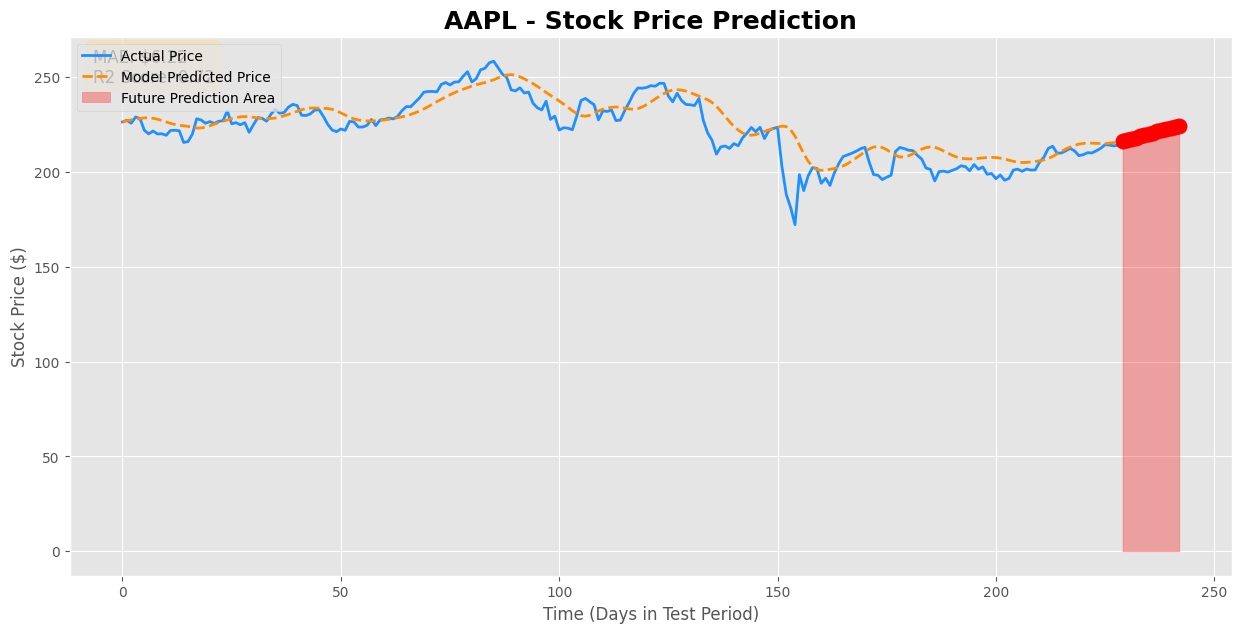

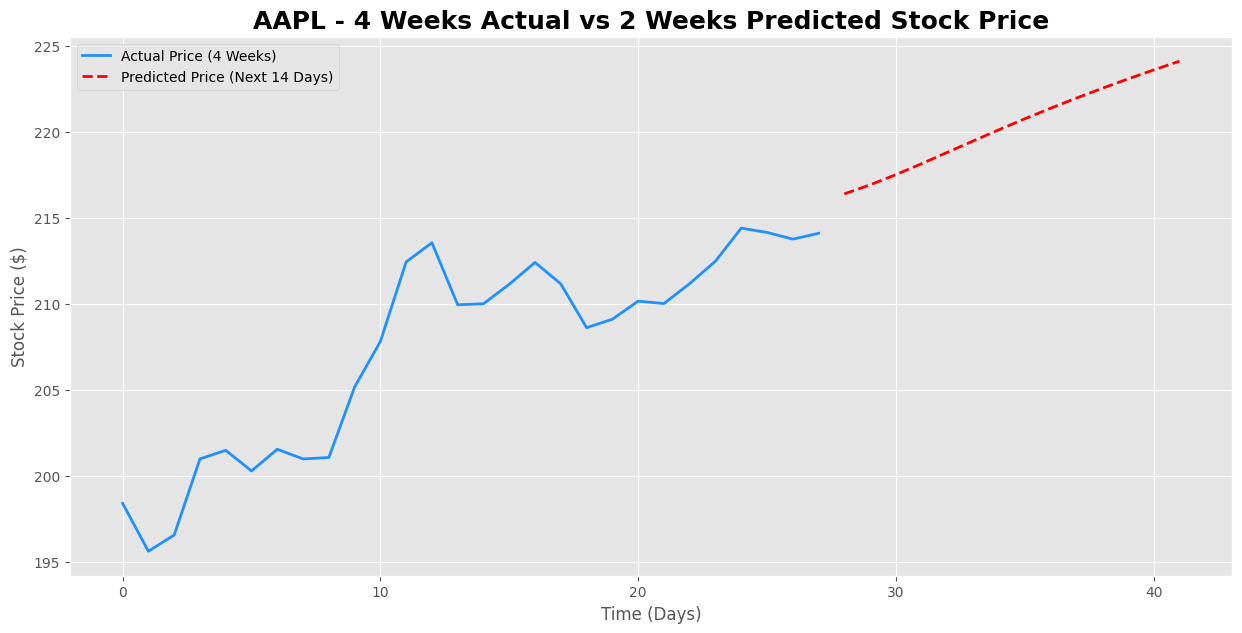


Performance Metrics for AAPL:
  - Mean Absolute Error (MAE): $6.22
  - R-squared (R2 Score): 0.72


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os
from tensorflow.keras.models import load_model

def plot_future_predictions(y_actual, y_pred, future_preds, ticker, mae, r2):
    """
    Plots the actual vs. predicted stock prices and includes the next 14 days forecast.
    Additionally shows error metrics like MAE and R2 on the graph.
    """
    plt.figure(figsize=(15, 7))

    plt.plot(y_actual, label='Actual Price', color='dodgerblue', linewidth=2)
    plt.plot(y_pred, label='Model Predicted Price', linestyle='--', color='darkorange', linewidth=2)

    future_index_start = len(y_actual)
    future_index_end = future_index_start + len(future_preds) - 1
    plt.fill_between(np.arange(future_index_start, future_index_end+1), future_preds, color='red', alpha=0.3, label="Future Prediction Area")

    plt.scatter(np.arange(future_index_start, future_index_end+1), future_preds, color='red', marker='o', s=120, zorder=5)

    plt.title(f'{ticker} - Stock Price Prediction', fontsize=18, fontweight='bold')
    plt.xlabel('Time (Days in Test Period)', fontsize=12)
    plt.ylabel('Stock Price ($)', fontsize=12)

    info_text = f"MAE: ${mae:.2f}\nR2 Score: {r2:.2f}"
    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.7))

    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()

def plot_actual_vs_predicted_week(ticker, actual_data, predicted_data, future_preds):
    """
    Plots 4 weeks of actual stock prices (28 days) and the next 14 days of predicted stock prices.
    """
    plt.figure(figsize=(15, 7))

    plt.plot(actual_data, label='Actual Price (4 Weeks)', color='dodgerblue', linewidth=2)

    plt.plot(np.arange(len(actual_data), len(actual_data) + len(future_preds)), future_preds,
             label='Predicted Price (Next 14 Days)', color='red', linestyle='--', linewidth=2)

    plt.title(f'{ticker} - 4 Weeks Actual vs 2 Weeks Predicted Stock Price', fontsize=18, fontweight='bold')
    plt.xlabel('Time (Days)', fontsize=12)
    plt.ylabel('Stock Price ($)', fontsize=12)

    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()

models_dir = 'trained_models'
if not os.path.exists(models_dir):
    print(f"Error: The directory '{models_dir}' was not found. Please run the new training cell first.")
else:
    tickers = list(stock_data_dict.keys())

    for ticker in tickers:
        print(f"\n{'='*50}")
        print(f" Generating Predictions for {ticker}")
        print(f"{'='*50}")

        model_path = os.path.join(models_dir, f"{ticker}_stock_model.keras")
        scaler_path = os.path.join(models_dir, f'{ticker}_scaler.gz')

        if not os.path.exists(model_path) or not os.path.exists(scaler_path):
            print(f"Model or scaler for {ticker} not found. Skipping.")
            continue

        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        print(f"Loaded model and scaler for {ticker}.")

        data = stock_data_dict[ticker].filter(['Price'])
        dataset = data.values
        training_data_len = int(np.ceil(len(dataset) * .8))

        scaled_data = scaler.transform(dataset)

        test_data = scaled_data[training_data_len - 60:, :]
        X_test_ticker, y_test_actual = [], []

        for i in range(60, len(test_data)):
            X_test_ticker.append(test_data[i-60:i, 0])
            y_test_actual.append(dataset[training_data_len + i - 60, 0])

        X_test_ticker = np.array(X_test_ticker)
        X_test_ticker = np.reshape(X_test_ticker, (X_test_ticker.shape[0], X_test_ticker.shape[1], 1))
        y_test_actual = np.array(y_test_actual).flatten()

        predictions_scaled = model.predict(X_test_ticker)
        predictions_inverse = scaler.inverse_transform(predictions_scaled).flatten()  #

        future_preds = []
        last_60_days_scaled = scaled_data[-60:]
        for _ in range(14):  # Predict for the next 14 days
            X_future_pred = np.reshape(last_60_days_scaled, (1, 60, 1))
            future_price_scaled = model.predict(X_future_pred)
            future_price_inverse = scaler.inverse_transform(future_price_scaled)[0][0]
            future_preds.append(future_price_inverse)

            last_60_days_scaled = np.append(last_60_days_scaled[1:], future_price_scaled, axis=0)

        mae = mean_absolute_error(y_test_actual, predictions_inverse)
        r2 = r2_score(y_test_actual, predictions_inverse)

        plot_future_predictions(y_test_actual, predictions_inverse, future_preds, ticker, mae, r2)
        plot_actual_vs_predicted_week(ticker, y_test_actual[-28:], predictions_inverse[-28:], future_preds)

        print(f"\nPerformance Metrics for {ticker}:")
        print(f"  - Mean Absolute Error (MAE): ${mae:.2f}")
        print(f"  - R-squared (R2 Score): {r2:.2f}")
